### Slowly decreasing and increasing the coupling

Instead of turning on/off the coupling suddenly, I'll consider the case where the coupling is slowly turned off (on) slowly. To turn off the coupling more slowly, I want the coupling to decrease by some constant $dK(t)/dt = c$. I'm gonna choose $c>0$

In general, the following piecewise function can model this situation:
$$
K(t) = \left\{\begin{array}{ll}
{K,} & {0 \leq t \leq t_1} \\
{-c(t-t_2),} & {t_1 < t\leq t_2}\\
{0,} & {t_2 < t \leq t_3}\\
{c(t-t_3)} & {t_3 < t \leq t_4}\\
{K} & {t > t_4}
\end{array}\right.
$$

As an example, I'll be using the following $K(t)$ for now, I'll explore what different parameters work best in the future.

$$
K(t) = \left\{\begin{array}{ll}
{K,} & {0 \leq t \leq t_1} \\
{-c(t-150),} & {t_1 < t\leq 100}\\
{0,} & {100 < t \leq 200}\\
{c(t-250)} & {200 < t \leq t_2}\\
{K} & {t > t_2}
\end{array}\right.
$$

Where $t_1 = -K/0.05 + 150$ and $t_2 = K/0.05 + 250$

In this case, we add a time dependence to $\Omega_r \rightarrow \Omega_r(t)^2 = K(t)/m = \omega^2 - \omega_0^2 $. 

$$
\Omega_r(t) = \left\{\begin{array}{ll}
{\sqrt{K/m},} & {0 \leq t \leq t_1} \\
{\sqrt{-c(t-150)/m},} & {t_1 < t\leq 100}\\
{0,} & {100 < t \leq 200}\\
{\sqrt{c(t-250)/m}} & {200 < t \leq t_2}\\
{\sqrt{K/m}} & {t > t_3}
\end{array}\right.
$$

Solve for $t_1$ and $t_2$ in terms of $\omega$ and $\omega_0$:

$$
\begin{aligned}
t_1 &= -\frac{K}{c} + 100\\
&= -\frac{m \Omega_r^2}{c} + 100\\
&= -\frac{m (\omega^2 - \omega_0^2)}{c} + 100
\end{aligned}
$$

$$
\begin{aligned}
t_2 &= \frac{K}{c} + 200\\
&= \frac{m \Omega_r^2}{c} + 200\\
&= \frac{m (\omega^2 - \omega_0^2)}{c} + 200
\end{aligned}
$$

In [3]:
# Most of the code is taken from MassSpringEITTransient.py with a few changes

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import scipy.integrate as sci

In [19]:
# Use the same parameters:
# I'm going to cheat a bit with the units in time and let mass=1 then F=1
gamma1 = 0.01
gamma2 = 0.01
omega0 = 0.71
OmegaR = np.sqrt(1-omega0**2)
Foverm = 1
c = 0.005 # also i'm going to restrict 0<c<1

Text(0.5, 0, 'time: $1/\\omega$')

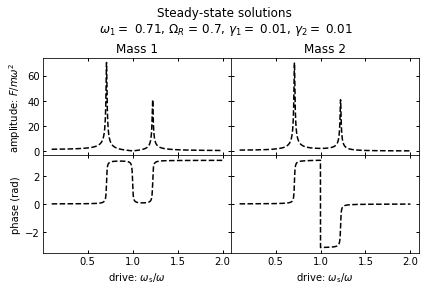

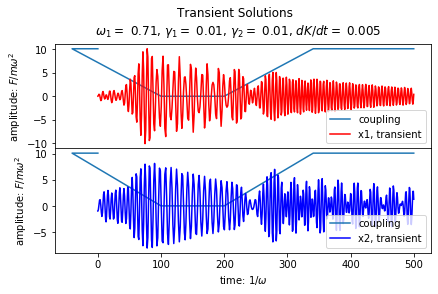

In [21]:
# Define Omega_r
def Omega_rt(omega0,t,c):
    # compute t_1 and t_2 first:
    t_1 = -np.sqrt(1-omega0**2)/c + 100
    t_2 = np.sqrt(1-omega0**2)/c + 200
    if t > t_1 and t <= 100:
        Omega_r = np.sqrt(-c*(t-100))
    elif t > 100 and t <= 200:
        Omega_r = 0
    elif t > 200 and t <= t_2:
        Omega_r = np.sqrt(c*(t-200))
    else:
        Omega_r = np.sqrt(1-omega0**2)
    return Omega_r

def CoupledMassODE(t,y,p):
    # y[0] = x1: position of driven mass
    # y[1] = x2: position of undriven mass
    # y[2]= d(x1)/ dt
    # y[3]= d(x2)/ dt
    # parameters, p
    # p = (omega0, gamma1,gamma2,F,omegas)
    out = [y[2],
           y[3],
          -p[1]*y[2] - (p[0]**2 + (Omega_rt(p[0],t,c))**2)*y[0] + (Omega_rt(p[0],t,c)**2)*y[1] + p[3]*np.cos(p[4]*t),
          -p[2]*y[3] - (p[0]**2 + (Omega_rt(p[0],t,c))**2)*y[1] + (Omega_rt(p[0],t,c)**2)*y[0]]
    return out

# *** Define parameters and ICs
params = [omega0,gamma1,gamma2,Foverm,1]
#y0 = [0+0j,0+0j,0+0j,0+0j]
y0 = [0,-Foverm,0,0] # without complex drive, use real ICs
# **************************************** 

# *** Solve ODEs
sol = sci.solve_ivp(lambda t,y: CoupledMassODE(t,y,params),(0,500),y0)

# Just to know when the coupling is turned off in the plot, plot the coupling strength
# I will be scaling so the strength of the coupling is not accurately reflected in the plots.
t_1 = -np.sqrt(1-omega0**2)/c + 100
t_2 = np.sqrt(1-omega0**2)/c + 200
times = np.array([0,t_1,100,200,t_2,np.max(sol.t)])
Kx1 = np.array([np.max(sol.y[0]),np.max(sol.y[0]),0,0,np.max(sol.y[0]),np.max(sol.y[0])])
Kx2 = np.array([np.max(sol.y[0]),np.max(sol.y[0]),0,0,np.max(sol.y[0]),np.max(sol.y[0])])

# Steady State solutions
# When t->inf then OmegaR should take on OmegaR = np.sqrt(1-omega0**2)

# ******* x1: first mass dispacement ******* 
def x10single(omegas,omega0,gamma1,gamma2,F):
    # displacement of first mass
    # returns two arguments: amplitude and phase
    OmegaR = np.sqrt(1-omega0**2)
    x1 = ((1 - omegas**2 - 1j*gamma2*omegas)*F / 
            ((1 - omegas**2 - 1j*gamma1*omegas)*(1 - omegas**2 - 1j*gamma2*omegas)-OmegaR**4))
    return np.abs(x1),np.angle(x1)

x10 = np.frompyfunc(x10single,5,2)
# **************************************** 
      
      
# ******* x2: second mass dispacement ******* 
def x20single(omegas,omega0,gamma1,gamma2):
    # displacement of second mass
    # returns two arguments: amplitude and phase
    OmegaR = np.sqrt(1-omega0**2)
    x2= (OmegaR**2*Foverm / 
            ((1 - omegas**2 - 1j*gamma1*omegas)*(1 - omegas**2 - 1j*gamma2*omegas)-OmegaR**4))
    return np.abs(x2),np.angle(x2)

x20 = np.frompyfunc(x20single,4,2)
# **************************************** 


drives = np.linspace(0.1,2,2000)
x1sA,x1sph = x10(drives,omega0,gamma1,gamma2,Foverm)
x2sA,x2sph = x20(drives,omega0,gamma1,gamma2)   


# ******* Plotting ******************************* 
# Steady states
f1 = plt.figure(1,figsize = (6,4))
plt.clf()
gs = gridspec.GridSpec(2,2,top = 0.80,left = 0.08,right = 0.95,hspace = 0,wspace = 0)
f1.suptitle('Steady-state solutions\n $\omega_1 =$ {:.2}, $\Omega_R$ = {:.2}, $\gamma_1 =$ {:.2}, $\gamma_2 =$ {:.2}'.format(omega0,OmegaR,gamma1,gamma2) )
#
# x1, amplitude
ax1 = plt.subplot(gs[0])
ax1.plot(drives, x1sA, 'k--')
ax1.set_title('Mass 1')
ax1.tick_params(axis = 'both',width=1, length = 3,direction = 'in',top='true',right = 'true')
ax1.set_xticklabels([])
ax1.set_ylabel(r'amplitude: $F/m\omega^2$')
ylims1 =ax1.get_ylim()

# x1, phase
ax3 = plt.subplot(gs[2])
ax3.plot(drives, x1sph, 'k--')
ax3.tick_params(axis = 'both',width=1, length = 3,direction = 'in',top='true',right = 'true')
ax3.set_ylim(-3.5,3.5)
ax3.set_xlabel(r'drive: $\omega_{\rm s}/\omega$')
ax3.set_ylabel(r'phase (rad)')


# x2 amplitude
ax2 = plt.subplot(gs[1])
ax2.plot(drives, x2sA, 'k--')
ax2.set_title('Mass 2')
ax2.tick_params(axis = 'both',width=1, length = 3,direction = 'in',top='true',right = 'true')
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_ylim(ylims1)

# x2, phase
ax4 = plt.subplot(gs[3])
ax4.plot(drives, x2sph, 'k--')
ax4.set_ylim(-3.5,3.5)
ax4.set_yticklabels([])
ax4.tick_params(axis = 'both',width=1, length = 3,direction = 'in',top='true',right = 'true')
ax4.set_xlabel(r'drive: $\omega_{\rm s}/\omega$')

# *** Plotting
# Transient states
f2 = plt.figure(2,figsize = (6,4))
plt.clf()
f2.suptitle('Transient Solutions \n $\omega_1 =$ {:.2}, $\gamma_1 =$ {:.2}, $\gamma_2 =$ {:.2}, $dK/dt=$ {:.3}'.format(omega0,gamma1,gamma2,c) )
gs1 = gridspec.GridSpec(2,1,top = 0.85,left = 0.08,right = 0.95,hspace = 0,wspace = 0)

# Driven mass position
ax1 = plt.subplot(gs1[0])
#ax1.plot(times,x1ss,'k-',alpha = 0.5,label = 'x1, steady state')
ax1.plot(times,Kx1,label='coupling')
ax1.plot(sol.t,sol.y[0],'r-',label = 'x1, transient')
ax1.legend(loc=4)
ax1.set_ylabel(r'amplitude: $F/m\omega^2$')

# Passive mass position
ax2 = plt.subplot(gs1[1])
#ax2.plot(times,x2ss,'k-',alpha = 0.5,label = 'x2, steady state')
ax2.plot(times,Kx2,label='coupling')
ax2.plot(sol.t,sol.y[1],'b-',label = 'x2, transient')
ax2.legend(loc =4)
ax2.set_ylabel(r'amplitude: $F/m\omega^2$')
ax2.set_xlabel(r'time: $1/\omega$')